# Trend Prediction on Resting Heart Rate

In [1]:
import pandas as pd
from contextlib import closing
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import codecs
from utils import *
from datetime import datetime
from dateutil.relativedelta import relativedelta

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)
plt.style.use('ggplot')
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Trend Prediction

## Load Data

In [3]:
train = pd.read_csv('health_state_prediction/data/train.csv', index_col=False)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Columns: 392 entries, userID to target
dtypes: bool(2), float64(372), int64(16), object(2)
memory usage: 497.0+ KB


In [4]:
test = pd.read_csv('health_state_prediction/data/test.csv', index_col=False)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Columns: 392 entries, userID to target
dtypes: bool(2), float64(372), int64(16), object(2)
memory usage: 158.6+ KB


In [5]:
patterns = {}
with open('health_state_prediction/data/tmp/exercise_patterns.decomposed.pkl', 'rb') as f:
    patterns['Ep'] = pkl.load(f)
with open('health_state_prediction/data/exercise_patterns.decomposed.pkl', 'rb') as f:
    patterns['Ed'] = pkl.load(f)

## Select Features

In [6]:
U = ['age', 'height', 'weight', 'gender']
Er = list(filter(lambda x: x.startswith('effectTime_mean_'), train.columns)) + \
     list(filter(lambda x: x.startswith('count_'), train.columns))
Eb = list(filter(lambda x: x.startswith('cluster_'), train.columns))

features = {
    'U': U,
    'U_Er': U + Er,
    'U_Eb': U + Eb,
    'U_Er_Eb': U + Er + Eb    
}

In [7]:
for key in features:
    print('[{}]\t Number of features: {}'.format(key, len(features[key])))

[U]	 Number of features: 4
[U_Er]	 Number of features: 124
[U_Eb]	 Number of features: 48
[U_Er_Eb]	 Number of features: 168


In [8]:
target = 'target'
train[target].value_counts()

1    93
0    70
Name: target, dtype: int64

## Classification Models

According to [http://scikit-learn.org/stable/supervised_learning.html](http://scikit-learn.org/stable/supervised_learning.html)

- [**Generalized Linear Models**](https://scikit-learn.org/stable/modules/linear_model.html)
    - [Logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
- [**Gaussian Process Classification (GPC)**](https://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-classification-gpc)
- [**Nearest Neighbors Classification**](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification)
    - [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)
    - [RadiusNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsClassifier.html#sklearn.neighbors.RadiusNeighborsClassifier)
- [**Support Vector Classifier**](https://scikit-learn.org/stable/modules/svm.html#classification)
    - [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
    - [NuSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html#sklearn.svm.NuSVC)
    - [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)
- [**Decision Tree Classification**](https://scikit-learn.org/stable/modules/tree.html#classification)
- [**Naive Bayes**](https://scikit-learn.org/stable/modules/naive_bayes.html)
    - [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)
- [**Ensemble Methods**](https://scikit-learn.org/stable/modules/ensemble.html)
    - [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)
    - [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier)
    - [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# https://scikit-learn.org/stable/modules/classes.html#classification-metrics
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

- [Receiver Operating Characteristic (ROC) with cross validation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py)
- [Precision-Recall](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#plot-the-precision-recall-curve)
- [Receiver Operating Characteristic (ROC)](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)

In [10]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score

In [11]:
def plot_ROC(y_test, y_score, n_classes=2):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr['positive'], tpr['positive'], _ = roc_curve(y_test, y_score)
    roc_auc['positive'] = auc(fpr['positive'], tpr['positive'])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure()
    lw = 2
    plt.plot(fpr['positive'], tpr['positive'], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc['positive'])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_PR(y_test, y_score):
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    average_precision = average_precision_score(y_test, y_score)
    
    plt.figure()
    lw = 2
    #plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    plt.fill_between(recall, precision, alpha=0.2, color='darkorange', **step_kwargs)
    plt.step(recall, precision, color='darkorange', where='post', 
             lw=lw, label='PR curve (average precision = %0.2f)' % average_precision)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision Recall curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_AUC(y_test, y_score):
    plot_ROC(y_test, y_score)
    plot_PR(y_test, y_score)

In [12]:
def fit_predict(model, X, Y, X_test, Y_test, target_names=['Not Healthier', 'Healthier'], verbose=True):
    model.fit(X, Y)
    
    if verbose:
        print('='*20 + 'train' + '='*20 )
        Y_pred = model.predict(X)    
        print(classification_report(Y, Y_pred, target_names=target_names))

        print('='*20 + 'test' + '='*20 )
        Y_pred = model.predict(X_test) 
        print(classification_report(Y_test, Y_pred, target_names=target_names))
    
    try:
        print(model.named_steps['clf'].best_params_)
    except: 
        pass
    print('')
    
    try:
        plot_AUC(Y_test, model.decision_function(X_test))
    except AttributeError:
        pass
    
    accuracy, precision, recall = accuracy_score(Y_test, Y_pred), precision_score(Y_test, Y_pred), recall_score(Y_test, Y_pred)
    print('accuracy', 'precision', 'recall', sep='\t')
    print(accuracy, precision, recall, '\n', sep='\t')
    
    return model

In [13]:
def k_fold_cross_validation(model, train, feat_cols, target, K=10, target_names=['Not Healthier', 'Healthier'], verbose=False):
    accuracy, precision, recall = [], [], []
    
    try:
        if type(model) is GridSearchCV:
            clf = model.best_estimator_
        else:
            clf = model.named_steps['clf'].best_estimator_
    except:
        clf = model.named_steps['clf']
    
    kf = KFold(n_splits=K, shuffle=False)
    for i, (train_index, dev_index) in enumerate(kf.split(train.values)):
        X_train, Y_train = X[train_index], Y[train_index]
        X_test, Y_test = X[dev_index], Y[dev_index]
        clf.fit(X_train, Y_train)
        
        Y_pred = clf.predict(X_test) 
        if verbose:
            print("="*20, "train", "="*20)
            print(classification_report(Y_train, model.predict(X_train), target_names=target_names))
            print("="*20, "test", "="*20)
            print(classification_report(Y_test, Y_pred, target_names=target_names))

        accuracy.append(accuracy_score(Y_test, Y_pred))
        precision.append(precision_score(Y_test, Y_pred))
        recall.append(recall_score(Y_test, Y_pred))
    
    accuracy, precision, recall = np.mean(accuracy), np.mean(precision), np.mean(recall)
    print('accuracy', 'precision', 'recall', sep='\t')
    print(accuracy, precision, recall, '\n', sep='\t')

In [52]:
def get_dict_value(dic, key, fill_val=False):
    if key in dic:
        return dic[key]
    else:
        return fill_val
    
def fill_duration_context(dic, key, duration_range=range(1,5), fill_val=0):
    user, m = key
    m = datetime.strptime(m, "%Y-%m-01")
    
    data = []
    for i in duration_range:
        data.extend(get_dict_value(dic, (user, str(m + relativedelta(months=i))[:7]), fill_val))
    return data

def prepare_samples(train, feat_cols, target, key='Ep'):
    Y = train[target].values
    
    n_ptn = len(list(patterns[key].values())[0])
    ptn_features = [fill_duration_context(patterns[key], k, fill_val=[False]*n_ptn) for k in zip(train['userID'], train['time_window'])]
    train = train[feat_cols]
    for i in range(len(ptn_features[0])):
        train['{}'.format(i)] = [ptn[i] for ptn in ptn_features]
    X = train.values
    
    return X, Y

### 1. Gaussian Naive Bayes

In [53]:
model = Pipeline([#('select', VarianceThreshold()),
                  ('scale', StandardScaler()),
                  ('poly', PolynomialFeatures()),
                  ('clf', GaussianNB())])

In [719]:
gnb = {}
for key in features:
    print('[{}]'.format(key))
    feat_cols = features[key]
    X, Y = train[feat_cols].values, train[target].values
    X_test, Y_test = test[feat_cols].values, test[target].values
    gnb[key] = fit_predict(model, X, Y, X_test, Y_test)
    
#     print("="*20 + "10 fold" + "="*20)
#     k_fold_cross_validation(gnb[key], train, feat_cols, target, K=10, verbose=False)

[U]
====================train====================
               precision    recall  f1-score   support

Not Healthier       0.50      0.87      0.63        70
    Healthier       0.78      0.33      0.47        93

    micro avg       0.56      0.56      0.56       163
    macro avg       0.64      0.60      0.55       163
 weighted avg       0.66      0.56      0.54       163

====================test====================
               precision    recall  f1-score   support

Not Healthier       0.47      0.63      0.54        30
    Healthier       0.08      0.05      0.06        22

    micro avg       0.38      0.38      0.38        52
    macro avg       0.28      0.34      0.30        52
 weighted avg       0.31      0.38      0.34        52


accuracy	precision	recall
0.38461538461538464	0.08333333333333333	0.045454545454545456	

====================10 fold====================
accuracy	precision	recall
0.4235294117647059	0.5398774509803921	0.6887432012432012	

[U_Er]
=========

In [720]:
with open('health_state_prediction/saved/models/gnb.pkl', 'wb') as f:
    pkl.dump(gnb, f)

_Ablation study..._

In [54]:
for key in ['Ep', 'Ed']:
    print('[{}]'.format(key))
    X, Y = prepare_samples(train, features['U'], target, key)
    X_test, Y_test = prepare_samples(test, features['U'], target, key)
    model = fit_predict(model, X, Y, X_test, Y_test)

[Ep]
====================train====================
               precision    recall  f1-score   support

Not Healthier       0.46      1.00      0.63        70
    Healthier       1.00      0.12      0.21        93

    micro avg       0.50      0.50      0.50       163
    macro avg       0.73      0.56      0.42       163
 weighted avg       0.77      0.50      0.39       163

====================test====================
               precision    recall  f1-score   support

Not Healthier       0.58      1.00      0.73        30
    Healthier       0.00      0.00      0.00        22

    micro avg       0.58      0.58      0.58        52
    macro avg       0.29      0.50      0.37        52
 weighted avg       0.33      0.58      0.42        52


accuracy	precision	recall
0.5769230769230769	0.0	0.0	

[Ed]
====================train====================
               precision    recall  f1-score   support

Not Healthier       0.50      0.97      0.66        70
    Healthier       

### 2. Logistic Regression

In [55]:
parameters = {'penalty':['l2'], 
              'tol':[1e-8],
              'C':[1e-15, 1e-12, 1e-10, 1e-8, 1e-6, 1e-3, 1e-2, 0.05, 0.1, 0.25, 0.5, 1., 2.5, 5., 10.], 
              'solver': ['lbfgs'],
              'max_iter':[1e+3]}
model = Pipeline([#('select', VarianceThreshold()),
                  ('scale', StandardScaler()),
                  ('poly', PolynomialFeatures()),
                  ('clf', GridSearchCV(LogisticRegression(), parameters, cv=5, iid=False))])

[U]
====================train====================
               precision    recall  f1-score   support

Not Healthier       0.66      0.27      0.38        70
    Healthier       0.62      0.89      0.73        93

    micro avg       0.63      0.63      0.63       163
    macro avg       0.64      0.58      0.56       163
 weighted avg       0.63      0.63      0.58       163

====================test====================
               precision    recall  f1-score   support

Not Healthier       0.45      0.17      0.24        30
    Healthier       0.39      0.73      0.51        22

    micro avg       0.40      0.40      0.40        52
    macro avg       0.42      0.45      0.38        52
 weighted avg       0.43      0.40      0.36        52

{'C': 0.05, 'max_iter': 1000.0, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 1e-08}



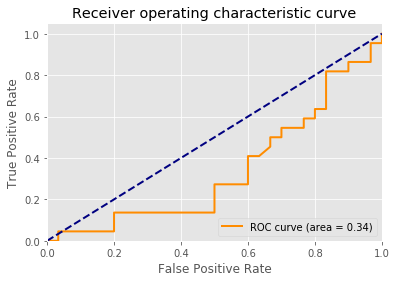

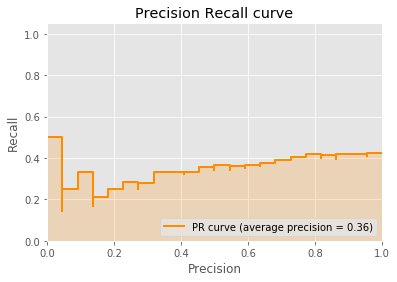

accuracy	precision	recall
0.40384615384615385	0.3902439024390244	0.7272727272727273	

====================10 fold====================
accuracy	precision	recall
0.5161764705882353	0.5514282531194297	0.9082051282051282	

[U_Er]
====================train====================
               precision    recall  f1-score   support

Not Healthier       0.84      0.39      0.53        70
    Healthier       0.67      0.95      0.79        93

    micro avg       0.71      0.71      0.71       163
    macro avg       0.76      0.67      0.66       163
 weighted avg       0.75      0.71      0.68       163

====================test====================
               precision    recall  f1-score   support

Not Healthier       0.45      0.17      0.24        30
    Healthier       0.39      0.73      0.51        22

    micro avg       0.40      0.40      0.40        52
    macro avg       0.42      0.45      0.38        52
 weighted avg       0.43      0.40      0.36        52

{'C': 1e-15, 'max

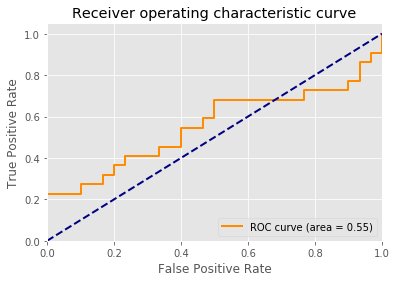

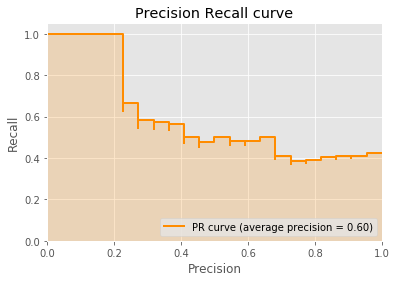

accuracy	precision	recall
0.40384615384615385	0.3902439024390244	0.7272727272727273	

====================10 fold====================
accuracy	precision	recall
0.5540441176470589	0.5705723443223443	0.9143278943278943	

[U_Eb]
====================train====================
               precision    recall  f1-score   support

Not Healthier       0.88      0.40      0.55        70
    Healthier       0.68      0.96      0.79        93

    micro avg       0.72      0.72      0.72       163
    macro avg       0.78      0.68      0.67       163
 weighted avg       0.76      0.72      0.69       163

====================test====================
               precision    recall  f1-score   support

Not Healthier       0.50      0.07      0.12        30
    Healthier       0.42      0.91      0.57        22

    micro avg       0.42      0.42      0.42        52
    macro avg       0.46      0.49      0.34        52
 weighted avg       0.46      0.42      0.31        52

{'C': 1e-15, 'max

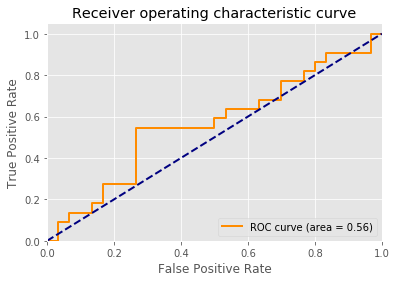

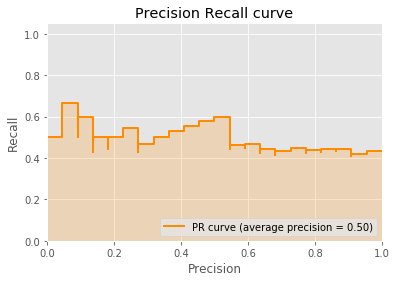

accuracy	precision	recall
0.4230769230769231	0.4166666666666667	0.9090909090909091	

====================10 fold====================
accuracy	precision	recall
0.5716911764705882	0.5716911764705882	1.0	

[U_Er_Eb]
====================train====================
               precision    recall  f1-score   support

Not Healthier       0.00      0.00      0.00        70
    Healthier       0.57      1.00      0.73        93

    micro avg       0.57      0.57      0.57       163
    macro avg       0.29      0.50      0.36       163
 weighted avg       0.33      0.57      0.41       163

====================test====================
               precision    recall  f1-score   support

Not Healthier       0.00      0.00      0.00        30
    Healthier       0.42      1.00      0.59        22

    micro avg       0.42      0.42      0.42        52
    macro avg       0.21      0.50      0.30        52
 weighted avg       0.18      0.42      0.25        52

{'C': 1e-12, 'max_iter': 1000.

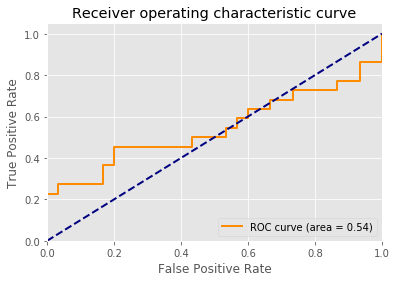

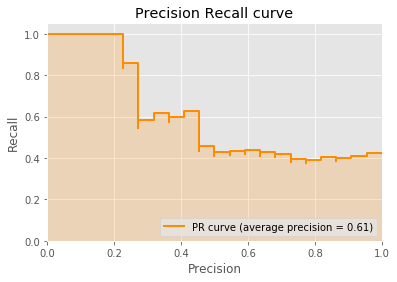

accuracy	precision	recall
0.4230769230769231	0.4230769230769231	1.0	

====================10 fold====================
accuracy	precision	recall
0.5599264705882353	0.5739056776556776	0.9243278943278945	



In [722]:
lr = {}
for key in features:
    print('[{}]'.format(key))
    feat_cols = features[key]
    X, Y = train[feat_cols].values, train[target].values
    X_test, Y_test = test[feat_cols].values, test[target].values
    lr[key] = fit_predict(model, X, Y, X_test, Y_test)
    
#     print("="*20 + "10 fold" + "="*20)
#     k_fold_cross_validation(lr[key], train, feat_cols, target, K=10, verbose=False)

In [723]:
with open('health_state_prediction/saved/models/lr.pkl', 'wb') as f:
    pkl.dump(lr, f)

_Ablation study..._

[Ep]
====================train====================
               precision    recall  f1-score   support

Not Healthier       0.79      0.70      0.74        70
    Healthier       0.79      0.86      0.82        93

    micro avg       0.79      0.79      0.79       163
    macro avg       0.79      0.78      0.78       163
 weighted avg       0.79      0.79      0.79       163

====================test====================
               precision    recall  f1-score   support

Not Healthier       0.54      0.43      0.48        30
    Healthier       0.39      0.50      0.44        22

    micro avg       0.46      0.46      0.46        52
    macro avg       0.47      0.47      0.46        52
 weighted avg       0.48      0.46      0.46        52

{'C': 0.05, 'max_iter': 1000.0, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 1e-08}



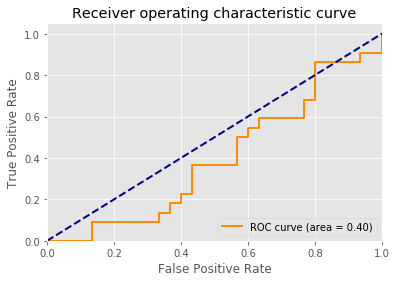

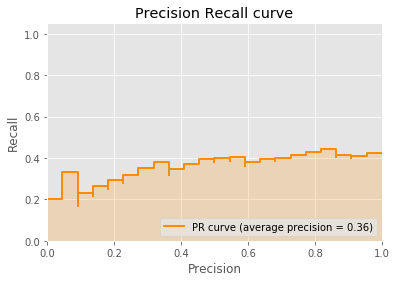

accuracy	precision	recall
0.46153846153846156	0.39285714285714285	0.5	

[Ed]
====================train====================
               precision    recall  f1-score   support

Not Healthier       0.77      0.76      0.76        70
    Healthier       0.82      0.83      0.82        93

    micro avg       0.80      0.80      0.80       163
    macro avg       0.79      0.79      0.79       163
 weighted avg       0.80      0.80      0.80       163

====================test====================
               precision    recall  f1-score   support

Not Healthier       0.48      0.53      0.51        30
    Healthier       0.26      0.23      0.24        22

    micro avg       0.40      0.40      0.40        52
    macro avg       0.37      0.38      0.38        52
 weighted avg       0.39      0.40      0.40        52

{'C': 0.01, 'max_iter': 1000.0, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 1e-08}



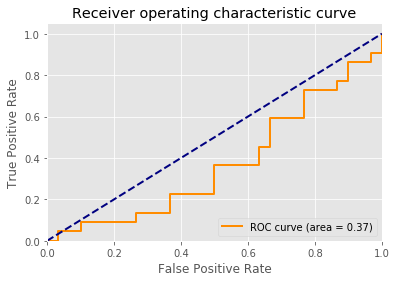

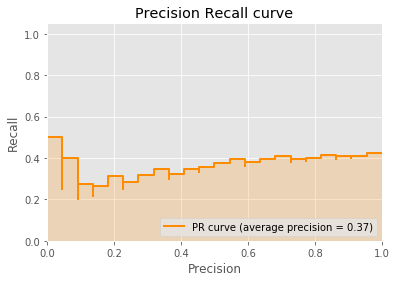

accuracy	precision	recall
0.40384615384615385	0.2631578947368421	0.22727272727272727	



In [56]:
for key in ['Ep', 'Ed']:
    print('[{}]'.format(key))
    X, Y = prepare_samples(train, features['U'], target, key)
    X_test, Y_test = prepare_samples(test, features['U'], target, key)
    model = fit_predict(model, X, Y, X_test, Y_test)

### 3. K Nearest Neighbor

In [57]:
parameters = {'n_neighbors':[i for i in range(3, 11)], 
              'weights':['distance', 'uniform']}
model = Pipeline([#('select', VarianceThreshold()),
                  ('scale', StandardScaler()),
                  ('poly', PolynomialFeatures()),
                  ('clf', GridSearchCV(KNeighborsClassifier(), parameters, cv=5, iid=False))])

In [725]:
knn = {}
for key in features:
    print('[{}]'.format(key))
    feat_cols = features[key]
    X, Y = train[feat_cols].values, train[target].values
    X_test, Y_test = test[feat_cols].values, test[target].values
    knn[key] = fit_predict(model, X, Y, X_test, Y_test)
    
#     print("="*20 + "10 fold" + "="*20)
#     k_fold_cross_validation(knn[key], train, feat_cols, target, K=10, verbose=False)

[U]
====================train====================
               precision    recall  f1-score   support

Not Healthier       0.87      0.94      0.90        70
    Healthier       0.95      0.89      0.92        93

    micro avg       0.91      0.91      0.91       163
    macro avg       0.91      0.92      0.91       163
 weighted avg       0.92      0.91      0.91       163

====================test====================
               precision    recall  f1-score   support

Not Healthier       0.38      0.27      0.31        30
    Healthier       0.29      0.41      0.34        22

    micro avg       0.33      0.33      0.33        52
    macro avg       0.34      0.34      0.33        52
 weighted avg       0.34      0.33      0.32        52

{'n_neighbors': 6, 'weights': 'distance'}

accuracy	precision	recall
0.3269230769230769	0.2903225806451613	0.4090909090909091	

====================10 fold====================
accuracy	precision	recall
0.5580882352941177	0.6794552669552669

In [726]:
with open('health_state_prediction/saved/models/knn.pkl', 'wb') as f:
    pkl.dump(knn, f)

_Ablation study..._

In [58]:
for key in ['Ep', 'Ed']:
    print('[{}]'.format(key))
    X, Y = prepare_samples(train, features['U'], target, key)
    X_test, Y_test = prepare_samples(test, features['U'], target, key)
    model = fit_predict(model, X, Y, X_test, Y_test)

[Ep]
====================train====================
               precision    recall  f1-score   support

Not Healthier       0.99      1.00      0.99        70
    Healthier       1.00      0.99      0.99        93

    micro avg       0.99      0.99      0.99       163
    macro avg       0.99      0.99      0.99       163
 weighted avg       0.99      0.99      0.99       163

====================test====================
               precision    recall  f1-score   support

Not Healthier       0.54      0.63      0.58        30
    Healthier       0.35      0.27      0.31        22

    micro avg       0.48      0.48      0.48        52
    macro avg       0.45      0.45      0.45        52
 weighted avg       0.46      0.48      0.47        52

{'n_neighbors': 9, 'weights': 'distance'}

accuracy	precision	recall
0.4807692307692308	0.35294117647058826	0.2727272727272727	

[Ed]
====================train====================
               precision    recall  f1-score   support

No

### 4. Random Forest

In [59]:
parameters = {'criterion':['gini', 'entropy'], 
              'n_estimators': [100],
              'max_features':['sqrt', 0.5, 0.7, 0.9], 
              'min_samples_leaf':[3, 5, 10], 
              'max_leaf_nodes':[2**i for i in range(3, 8)],
              'max_depth':[2**i for i in range(3, 7)]}
model = Pipeline([('scale', StandardScaler()),
                  ('clf', GridSearchCV(RandomForestClassifier(), parameters, cv=5, iid=False))])

In [771]:
rf = {}
for key in features:
    print('[{}]'.format(key))
    feat_cols = features[key]
    X, Y = train[feat_cols].values, train[target].values
    X_test, Y_test = test[feat_cols].values, test[target].values
    rf[key] = fit_predict(model, X, Y, X_test, Y_test)
    
#     print("="*20 + "10 fold" + "="*20)
#     k_fold_cross_validation(rf[key], train, feat_cols, target, K=10, verbose=False)

[U]
====================train====================
               precision    recall  f1-score   support

Not Healthier       0.90      0.76      0.82        70
    Healthier       0.84      0.94      0.88        93

    micro avg       0.86      0.86      0.86       163
    macro avg       0.87      0.85      0.85       163
 weighted avg       0.86      0.86      0.86       163

====================test====================
               precision    recall  f1-score   support

Not Healthier       0.57      0.43      0.49        30
    Healthier       0.41      0.55      0.47        22

    micro avg       0.48      0.48      0.48        52
    macro avg       0.49      0.49      0.48        52
 weighted avg       0.50      0.48      0.48        52

{'criterion': 'entropy', 'max_depth': 16, 'max_features': 0.5, 'max_leaf_nodes': 16, 'min_samples_leaf': 3, 'n_estimators': 100}

accuracy	precision	recall
0.4807692307692308	0.41379310344827586	0.5454545454545454	

[U_Er]
================

In [777]:
with open('health_state_prediction/saved/models/rf.pkl', 'wb') as f:
    pkl.dump(rf, f)

_Ablation study..._

In [60]:
for key in ['Ep', 'Ed']:
    print('[{}]'.format(key))
    X, Y = prepare_samples(train, features['U'], target, key)
    X_test, Y_test = prepare_samples(test, features['U'], target, key)
    model = fit_predict(model, X, Y, X_test, Y_test)

[Ep]
====================train====================
               precision    recall  f1-score   support

Not Healthier       0.81      0.79      0.80        70
    Healthier       0.84      0.86      0.85        93

    micro avg       0.83      0.83      0.83       163
    macro avg       0.83      0.82      0.82       163
 weighted avg       0.83      0.83      0.83       163

====================test====================
               precision    recall  f1-score   support

Not Healthier       0.49      0.60      0.54        30
    Healthier       0.20      0.14      0.16        22

    micro avg       0.40      0.40      0.40        52
    macro avg       0.34      0.37      0.35        52
 weighted avg       0.37      0.40      0.38        52

{'criterion': 'entropy', 'max_depth': 64, 'max_features': 'sqrt', 'max_leaf_nodes': 8, 'min_samples_leaf': 5, 'n_estimators': 100}

accuracy	precision	recall
0.40384615384615385	0.2	0.13636363636363635	

[Ed]
====================train====

### 5. Support Vector Machine

In [61]:
parameters = {'kernel':['rbf', 'poly', 'sigmoid'], 
              'C':[1e-5, 1e-3, 1e-2, 0.1, 0.5, 1, 2, 3, 5, 10], 
              'probability':[True]}
model = Pipeline([#('select', VarianceThreshold()),
                  ('scale', StandardScaler()),
                  ('poly', PolynomialFeatures()),
                  ('clf', GridSearchCV(SVC(), parameters, cv=5, iid=False))])

[U]
====================train====================
               precision    recall  f1-score   support

Not Healthier       1.00      0.01      0.03        70
    Healthier       0.57      1.00      0.73        93

    micro avg       0.58      0.58      0.58       163
    macro avg       0.79      0.51      0.38       163
 weighted avg       0.76      0.58      0.43       163

====================test====================
               precision    recall  f1-score   support

Not Healthier       0.00      0.00      0.00        30
    Healthier       0.42      1.00      0.59        22

    micro avg       0.42      0.42      0.42        52
    macro avg       0.21      0.50      0.30        52
 weighted avg       0.18      0.42      0.25        52

{'C': 0.01, 'kernel': 'poly', 'probability': True}



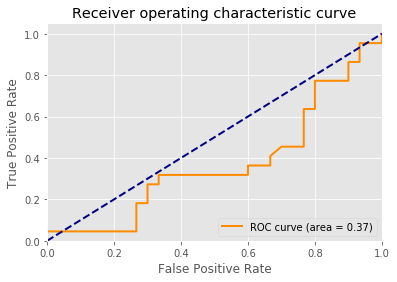

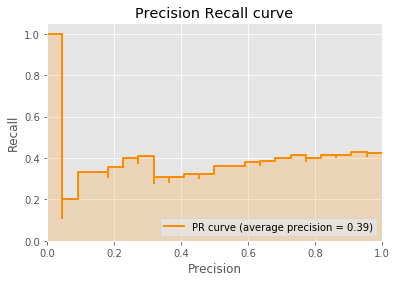

accuracy	precision	recall
0.4230769230769231	0.4230769230769231	1.0	

====================10 fold====================
accuracy	precision	recall
0.575	0.6298079698079697	0.6546386946386946	

[U_Er]
====================train====================
               precision    recall  f1-score   support

Not Healthier       0.00      0.00      0.00        70
    Healthier       0.57      1.00      0.73        93

    micro avg       0.57      0.57      0.57       163
    macro avg       0.29      0.50      0.36       163
 weighted avg       0.33      0.57      0.41       163

====================test====================
               precision    recall  f1-score   support

Not Healthier       0.00      0.00      0.00        30
    Healthier       0.42      1.00      0.59        22

    micro avg       0.42      0.42      0.42        52
    macro avg       0.21      0.50      0.30        52
 weighted avg       0.18      0.42      0.25        52

{'C': 1e-05, 'kernel': 'rbf', 'probability': T

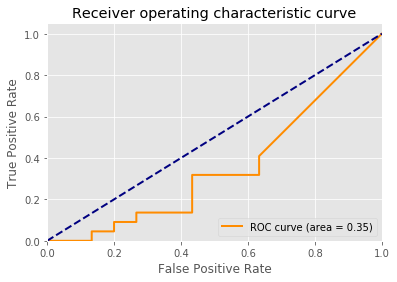

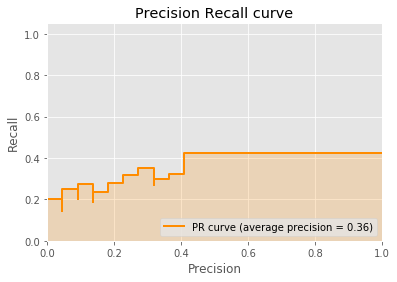

accuracy	precision	recall
0.4230769230769231	0.4230769230769231	1.0	

====================10 fold====================
accuracy	precision	recall
0.5716911764705882	0.5716911764705882	1.0	

[U_Eb]
====================train====================
               precision    recall  f1-score   support

Not Healthier       0.79      0.31      0.45        70
    Healthier       0.64      0.94      0.76        93

    micro avg       0.67      0.67      0.67       163
    macro avg       0.72      0.62      0.61       163
 weighted avg       0.71      0.67      0.63       163

====================test====================
               precision    recall  f1-score   support

Not Healthier       0.67      0.07      0.12        30
    Healthier       0.43      0.95      0.59        22

    micro avg       0.44      0.44      0.44        52
    macro avg       0.55      0.51      0.36        52
 weighted avg       0.57      0.44      0.32        52

{'C': 1, 'kernel': 'sigmoid', 'probability': Tru

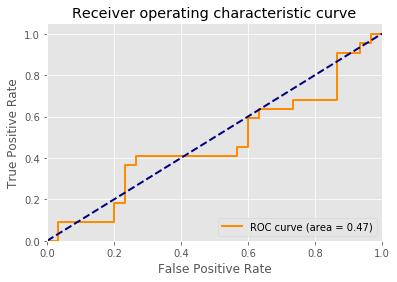

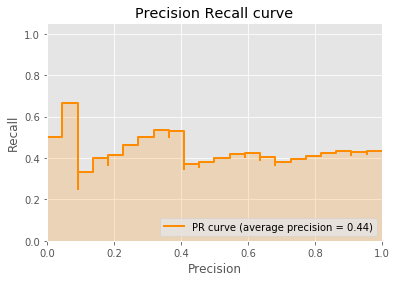

accuracy	precision	recall
0.4423076923076923	0.42857142857142855	0.9545454545454546	

====================10 fold====================
accuracy	precision	recall
0.5716911764705882	0.5716911764705882	1.0	

[U_Er_Eb]
====================train====================
               precision    recall  f1-score   support

Not Healthier       1.00      0.34      0.51        70
    Healthier       0.67      1.00      0.80        93

    micro avg       0.72      0.72      0.72       163
    macro avg       0.83      0.67      0.66       163
 weighted avg       0.81      0.72      0.68       163

====================test====================
               precision    recall  f1-score   support

Not Healthier       0.50      0.07      0.12        30
    Healthier       0.42      0.91      0.57        22

    micro avg       0.42      0.42      0.42        52
    macro avg       0.46      0.49      0.34        52
 weighted avg       0.46      0.42      0.31        52

{'C': 10, 'kernel': 'poly', '

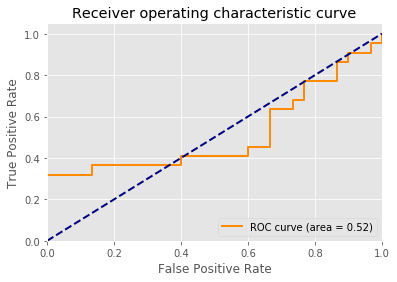

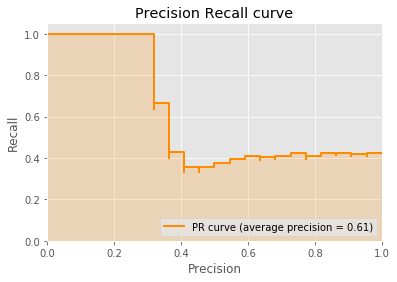

accuracy	precision	recall
0.4230769230769231	0.4166666666666667	0.9090909090909091	

====================10 fold====================
accuracy	precision	recall
0.49816176470588236	0.5507070707070707	0.5894483294483295	



In [731]:
svm = {}
for key in features:
    print('[{}]'.format(key))
    feat_cols = features[key]
    X, Y = train[feat_cols].values, train[target].values
    X_test, Y_test = test[feat_cols].values, test[target].values
    svm[key] = fit_predict(model, X, Y, X_test, Y_test)
    
#     print("="*20 + "10 fold" + "="*20)
#     k_fold_cross_validation(svm[key], train, feat_cols, target, K=10, verbose=False)

In [732]:
with open('health_state_prediction/saved/models/svm.pkl', 'wb') as f:
    pkl.dump(svm, f)

_Ablation study..._

[Ep]
====================train====================
               precision    recall  f1-score   support

Not Healthier       0.68      0.59      0.63        70
    Healthier       0.72      0.80      0.76        93

    micro avg       0.71      0.71      0.71       163
    macro avg       0.70      0.69      0.69       163
 weighted avg       0.70      0.71      0.70       163

====================test====================
               precision    recall  f1-score   support

Not Healthier       0.40      0.27      0.32        30
    Healthier       0.31      0.45      0.37        22

    micro avg       0.35      0.35      0.35        52
    macro avg       0.36      0.36      0.35        52
 weighted avg       0.36      0.35      0.34        52

{'C': 10, 'kernel': 'sigmoid', 'probability': True}



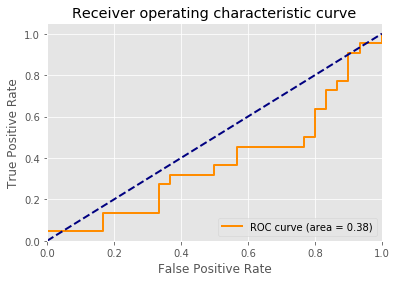

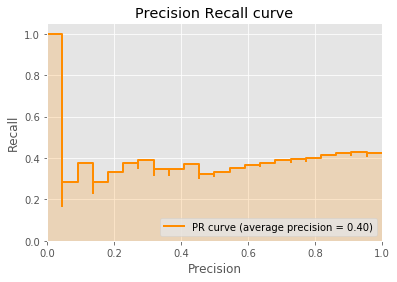

accuracy	precision	recall
0.34615384615384615	0.3125	0.45454545454545453	

[Ed]
====================train====================
               precision    recall  f1-score   support

Not Healthier       0.67      0.81      0.74        70
    Healthier       0.83      0.70      0.76        93

    micro avg       0.75      0.75      0.75       163
    macro avg       0.75      0.76      0.75       163
 weighted avg       0.76      0.75      0.75       163

====================test====================
               precision    recall  f1-score   support

Not Healthier       0.58      0.97      0.72        30
    Healthier       0.50      0.05      0.08        22

    micro avg       0.58      0.58      0.58        52
    macro avg       0.54      0.51      0.40        52
 weighted avg       0.55      0.58      0.45        52

{'C': 3, 'kernel': 'sigmoid', 'probability': True}



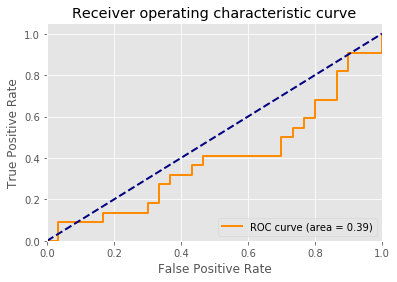

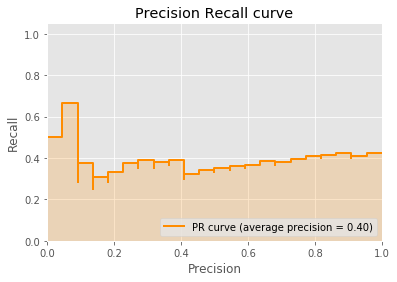

accuracy	precision	recall
0.5769230769230769	0.5	0.045454545454545456	



In [62]:
for key in ['Ep', 'Ed']:
    print('[{}]'.format(key))
    X, Y = prepare_samples(train, features['U'], target, key)
    X_test, Y_test = prepare_samples(test, features['U'], target, key)
    model = fit_predict(model, X, Y, X_test, Y_test)

---